In [1]:
import boto3
import json
import pandas as pd
from time import sleep

In [2]:
def setup_bedrock():
    """Initialize Bedrock client"""
    session = boto3.Session(region_name='ap-southeast-1')
    bedrock = session.client(
        service_name='bedrock-runtime',
        region_name='ap-southeast-1'
    )
    return bedrock

In [3]:
def classify_classification(text, bedrock_client):
    """
    Classify a single violation using Bedrock's Claude model
    """
    prompt = f"""Human: You are a news classifier. Given the following news description, classify it into one of these categories:
    - Politics
    - Sports
    - Technology
    - Entertainment
    - Business

    News description: {text}

    Respond with only the category name, nothing else.

    Assistant: """

    body = json.dumps({
        "prompt": prompt,
        "max_tokens_to_sample": 100,
        "temperature": 0,
        "top_p": 1,
        "anthropic_version": "bedrock-2023-05-31"
    })

    try:
        response = bedrock_client.invoke_model(
            modelId="anthropic.claude-v2",
            body=body
        )
        response_body = json.loads(response.get('body').read())
        return response_body.get('completion').strip()
    except Exception as e:
        print(f"Error processing text: {text}")
        print(f"Error: {str(e)}")
        return "Error in classification"

In [4]:
def process_news_batch(df, batch_size=25):
    """
    Process news in batches to avoid rate limits
    """
    # Initialize Bedrock client
    bedrock = setup_bedrock()
    classifications = []
    
    # Get the correct column name
    text_column = 'Text'
    
    for i in range(0, len(df), batch_size):
        batch = df[text_column].iloc[i:i+batch_size]
        print(f"Processing batch {i//batch_size + 1}/{len(df)//batch_size + 1}")
        
        batch_classifications = []
        for text in batch:
            classification = classify_classification(text, bedrock)
            batch_classifications.append(classification)
            sleep(0.5)  # Add delay to avoid rate limits
            
        classifications.extend(batch_classifications)
        
    return classifications

In [5]:
# Main execution
if __name__ == "__main__":
    # Read your data
    df = pd.read_csv("../data/raw/news_df_kaggle.csv")
    df = df[["Text"]]
    
    # Process the violations
    df['Category_Classified_by_Claude_LLM'] = process_news_batch(df)
    
    # Save results
    output_path = "../data/processed/news_df_kaggle_classified.csv"
    df.to_csv(output_path, index=False)
    print(f"\nResults saved to: {output_path}")

Processing batch 1/90
Processing batch 2/90
Processing batch 3/90
Processing batch 4/90
Processing batch 5/90
Processing batch 6/90
Processing batch 7/90
Processing batch 8/90
Processing batch 9/90
Processing batch 10/90
Processing batch 11/90
Processing batch 12/90
Processing batch 13/90
Processing batch 14/90
Processing batch 15/90
Processing batch 16/90
Processing batch 17/90
Processing batch 18/90
Processing batch 19/90
Processing batch 20/90
Processing batch 21/90
Processing batch 22/90
Processing batch 23/90
Processing batch 24/90
Processing batch 25/90
Processing batch 26/90
Processing batch 27/90
Processing batch 28/90
Processing batch 29/90
Processing batch 30/90
Processing batch 31/90
Processing batch 32/90
Processing batch 33/90
Processing batch 34/90
Processing batch 35/90
Processing batch 36/90
Processing batch 37/90
Processing batch 38/90
Processing batch 39/90
Processing batch 40/90
Processing batch 41/90
Processing batch 42/90
Processing batch 43/90
Processing batch 44/

In [6]:
df_processed = pd.read_csv("../data/processed/news_df_kaggle_classified.csv")
df_processed

,Text,Category_Classified_by_Claude_LLM
0,Budget to set scene for election\n \n Gordon B...,Politics
1,Army chiefs in regiments decision\n \n Militar...,Politics
2,Howard denies split over ID cards\n \n Michael...,Politics
3,Observers to monitor UK election\n \n Minister...,Politics
4,Kilroy names election seat target\n \n Ex-chat...,Politics
...,...,...
2220,India opens skies to competition\n \n India wi...,Business
2221,Yukos bankruptcy 'not US matter'\n \n Russian ...,Politics
2222,Survey confirms property slowdown\n \n Governm...,Business
2223,High fuel prices hit BA's profits\n \n British...,Business


In [7]:
# Bonus:
# Checking out the accuracy of classification
# Labels according to Kaggle:
# 0 - Politics, 1 - Sport, 2 - Technology, 3 - Entertainment, 4 - Business

df = pd.read_csv("../data/raw/news_df_kaggle.csv")

checking_df = df.merge(df_processed, on='Text', how='inner')
checking_df

,Text,Label,Category_Classified_by_Claude_LLM
0,Budget to set scene for election\n \n Gordon B...,0,Politics
1,Army chiefs in regiments decision\n \n Militar...,0,Politics
2,Howard denies split over ID cards\n \n Michael...,0,Politics
3,Howard denies split over ID cards\n \n Michael...,0,Politics
4,Observers to monitor UK election\n \n Minister...,0,Politics
...,...,...,...
2416,India opens skies to competition\n \n India wi...,4,Business
2417,Yukos bankruptcy 'not US matter'\n \n Russian ...,4,Politics
2418,Survey confirms property slowdown\n \n Governm...,4,Business
2419,High fuel prices hit BA's profits\n \n British...,4,Business


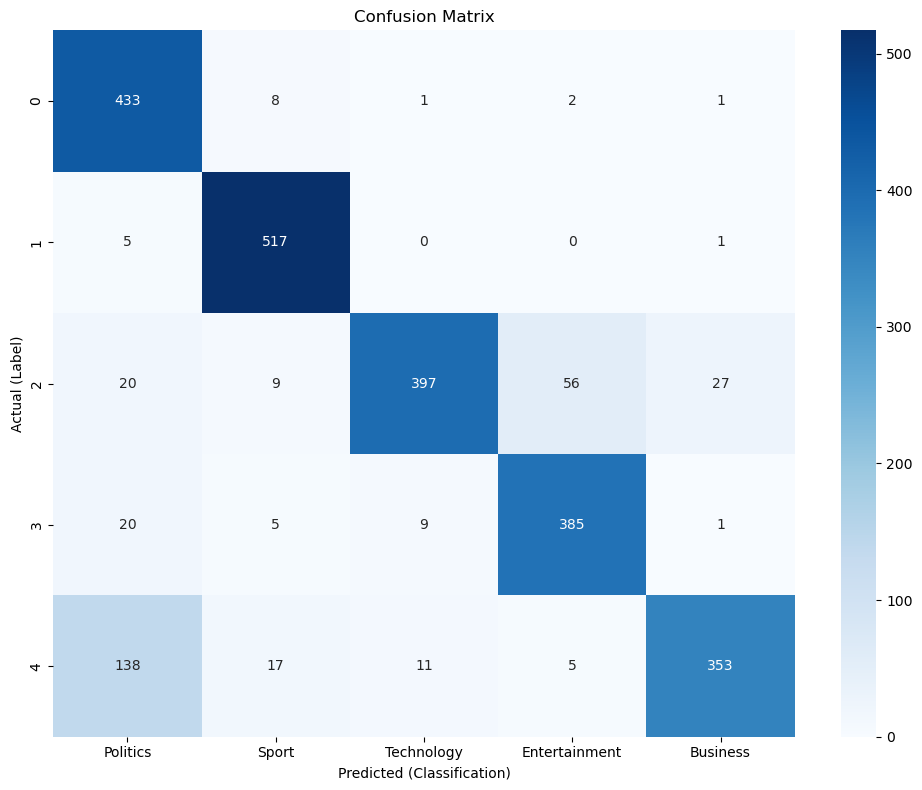

Overall accuracy: 86.12%

Classification Report per Category:
Label 0: 97.30%
Label 1: 98.85%
Label 2: 78.00%
Label 3: 91.67%
Label 4: 67.37%


In [17]:
# Compute the accuracy of the LLM as compared to the actual labels given by Kaggle

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Create a mapping dictionary to convert Classification strings to numbers
category_mapping = {
    'Politics': 0,
    'Sports': 1,
    'Technology': 2,
    'Entertainment': 3,
    'Business': 4
}

# Convert Classification strings to numbers for comparison
checking_df['Classification_Numeric'] = checking_df['Category_Classified_by_Claude_LLM'].map(category_mapping)

# Create confusion matrix
cm = confusion_matrix(checking_df['Label'], checking_df['Classification_Numeric'])

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, 
            annot=True, 
            fmt='d',
            cmap='Blues',
            xticklabels=['Politics', 'Sport', 'Technology', 'Entertainment', 'Business'],
            yticklabels=['0', '1', '2', '3', '4'])

plt.title('Confusion Matrix')
plt.xlabel('Predicted (Classification)')
plt.ylabel('Actual (Label)')
plt.tight_layout()
plt.show()

# Calculate accuracy
accuracy = (checking_df['Label'] == checking_df['Classification_Numeric']).mean()
print(f'Overall accuracy: {accuracy:.2%}')

# Detailed classification report
print("\nClassification Report per Category:")
for label in range(5):
    category_accuracy = (
        (checking_df['Label'] == checking_df['Classification_Numeric']) & 
        (checking_df['Label'] == label)
    ).sum() / (checking_df['Label'] == label).sum()
    print(f"Label {label}: {category_accuracy:.2%}")